# Training tutorial

## Introduction to symbols

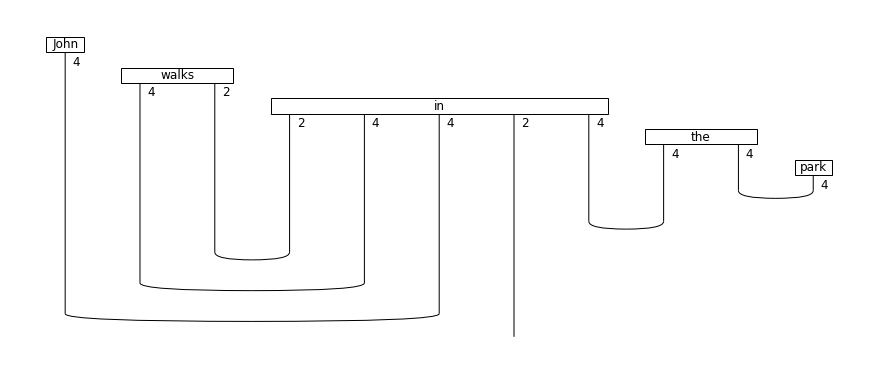

In [1]:
from lambeq.ccg2discocat import DepCCGParser
from lambeq.tensor import TensorAnsatz
from lambeq.core.types import AtomicType
from discopy import Dim

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Parse a sentence
parser = DepCCGParser()
diagram = parser.sentence2diagram("John walks in the park")

# Apply a tensor ansatz
ansatz = TensorAnsatz({N: Dim(4), S: Dim(2)})
tensor_diagram = ansatz(diagram)
tensor_diagram.draw(figsize=(12,5), fontsize=12)

In [2]:
tensor_diagram.free_symbols

{John__n, in__s.r@n.r.r@n.r@s@n.l, park__n, the__n@n.l, walks__n.r@s}

In [3]:
[s.size for s in tensor_diagram.free_symbols]

[16, 256, 4, 8, 4]

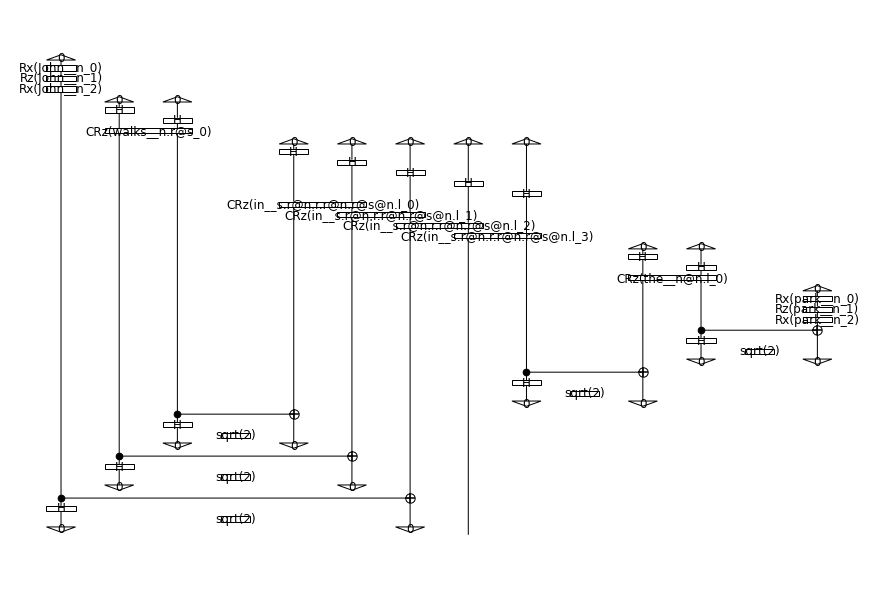

In [4]:
from lambeq.circuit import IQPAnsatz

iqp_ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=1)
circuit = iqp_ansatz(diagram)
circuit.draw(figsize=(12,8), fontsize=12)

In [5]:
[(s, s.size) for s in circuit.free_symbols]

[(in__s.r@n.r.r@n.r@s@n.l_3, 1),
 (John__n_0, 1),
 (park__n_2, 1),
 (in__s.r@n.r.r@n.r@s@n.l_0, 1),
 (John__n_2, 1),
 (park__n_1, 1),
 (John__n_1, 1),
 (walks__n.r@s_0, 1),
 (the__n@n.l_0, 1),
 (in__s.r@n.r.r@n.r@s@n.l_1, 1),
 (in__s.r@n.r.r@n.r@s@n.l_2, 1),
 (park__n_0, 1)]

In [6]:
from sympy import default_sort_key

parameters = sorted(tensor_diagram.free_symbols, key=default_sort_key)

In [7]:
import numpy as np

tensors = [np.random.rand(p.size) for p in parameters]
print(tensors[0])

[0.98111131 0.88772958 0.65068015 0.35379704]


In [8]:
tensor_diagram_np = tensor_diagram.lambdify(*parameters)(*tensors)
print("Before lambdify:", tensor_diagram.boxes[0].data)
print("After lambdify:", tensor_diagram_np.boxes[0].data)

Before lambdify: John__n
After lambdify: [0.98111131 0.88772958 0.65068015 0.35379704]


In [9]:
result = tensor_diagram_np.eval()
print(result)

Tensor(dom=Dim(1), cod=Dim(2), array=[27.50087004, 24.96694656])


In [10]:
result.array

array([27.50087004, 24.96694656])

## A complete use case

In [11]:
from discopy.tensor import Tensor
from jax import numpy as np
import numpy

np.random = numpy.random
Tensor.np = np

In [12]:
# Read data
def read_data(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    data, targets = [], []
    for ln in lines:
        t = int(ln[0])
        data.append(ln[1:].strip())
        targets.append(np.array([t, not(t)], dtype=np.float32))
    return data, np.array(targets)

train_data, train_targets = read_data('examples/datasets/mc_train_data.txt')
test_data, test_targets = read_data('examples/datasets/mc_test_data.txt')
dev_data, dev_targets = read_data('examples/datasets/mc_dev_data.txt')

In [13]:
train_data[:10]

['skillful man prepares sauce',
 'skillful man bakes dinner',
 'woman cooks tasty meal',
 'man prepares meal',
 'skillful woman debugs program',
 'woman prepares tasty meal',
 'person runs program',
 'person runs useful application',
 'woman prepares sauce',
 'woman prepares dinner']

In [14]:
train_targets

DeviceArray([[1., 0.],
             [1., 0.],
             [1., 0.],
             ...,
             [0., 1.],
             [1., 0.],
             [0., 1.]], dtype=float32)

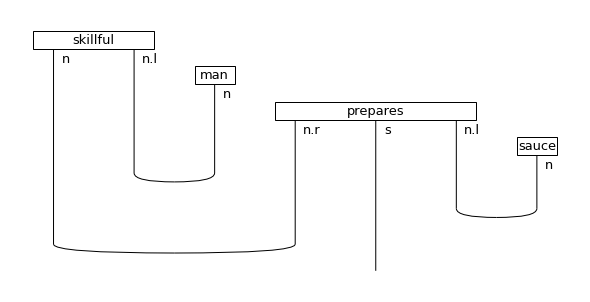

In [15]:
# Parse sentences to diagrams

from lambeq.ccg2discocat import DepCCGParser

parser = DepCCGParser()
train_diagrams = parser.sentences2diagrams(train_data)
test_diagrams = parser.sentences2diagrams(test_data)

train_diagrams[0].draw(figsize=(8,4), fontsize=13)

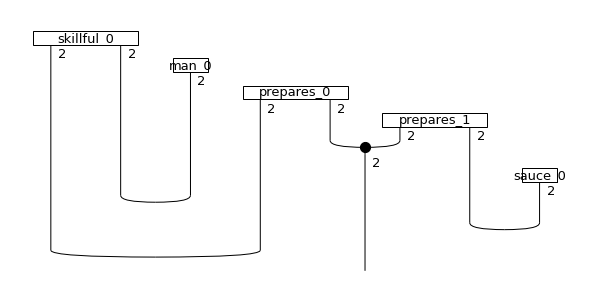

In [16]:
# Create ansatz and convert to tensor diagrams

from lambeq.tensor import SpiderAnsatz
from lambeq.core.types import AtomicType
from discopy import Dim

N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Create an ansatz by assigning 2 dimensions to both
# noun and sentence spaces
ansatz = SpiderAnsatz({N: Dim(2), S: Dim(2)})

train_circuits = [ansatz(d) for d in train_diagrams]
test_circuits = [ansatz(d) for d in test_diagrams]

all_circuits = train_circuits + test_circuits

all_circuits[0].draw(figsize=(8,4), fontsize=13)

In [17]:
# Create vocabulary

from sympy import default_sort_key

vocab = sorted(
   {sym for circ in all_circuits for sym in circ.free_symbols},
    key=default_sort_key
)
tensors = [np.random.rand(w.size) for w in vocab]

tensors[0]

array([0.35743395, 0.45764418])

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(tensors):
    # Lambdify
    np_circuits = [c.lambdify(*vocab)(*tensors) for c in train_circuits]
    # Compute predictions
    predictions =  sigmoid(np.array([c.eval().array for c in np_circuits]))

    # binary cross-entropy loss
    cost = -np.sum(train_targets * np.log2(predictions)) / len(train_targets)
    return cost

In [19]:
from jax import jit, grad

training_loss = jit(loss)
gradient = jit(grad(loss))

In [20]:
training_losses = []

epochs = 90

for i in range(epochs):

    gr = gradient(tensors)
    for k in range(len(tensors)):
        tensors[k] = tensors[k] - gr[k] * 1.0

    training_losses.append(float(training_loss(tensors)))

    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1} - loss {training_losses[-1]}")

Epoch 10 - loss 0.07233709841966629
Epoch 20 - loss 0.015333528630435467
Epoch 30 - loss 0.00786149874329567
Epoch 40 - loss 0.00515687046572566
Epoch 50 - loss 0.0037753921933472157
Epoch 60 - loss 0.0029438300989568233
Epoch 70 - loss 0.002392344642430544
Epoch 80 - loss 0.0020021884702146053
Epoch 90 - loss 0.001713048666715622


In [21]:
# Testing

np_test_circuits = [c.lambdify(*vocab)(*tensors) for c in test_circuits]
test_predictions =  sigmoid(np.array([c.eval().array for c in np_test_circuits]))

hits = 0
for i in range(len(np_test_circuits)):
    target = test_targets[i]
    pred = test_predictions[i]
    if np.argmax(target) == np.argmax(pred):
        hits += 1

print("Accuracy on test set:", hits / len(np_test_circuits))

Accuracy on test set: 0.9
